In [0]:
import os
import glob
import json
import cv2
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models, layers, optimizers, Input, Model
#array_to_img, img_to_array, load_img, save_img
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image, ImageDraw
from google.colab.patches import cv2_imshow

#PATHS
path_train_images = '/content/drive/My Drive/images/'
path_train_jsons = '/content/drive/My Drive/jsons/'
path_predict_images = '/content/drive/My Drive/predict_images/'

#READ FILES
image_files = glob.glob(os.path.join(path_train_images, "*.jpg"))
json_files = glob.glob(os.path.join(path_train_jsons, "*.json"))
predict_images = glob.glob(os.path.join(path_predict_images, "*.jpg"))

assert len(image_files)==len(json_files)

#PREPARE TRAIN, TEST, VALIDATION SETS
#set size
train = 0.7
test = round((1-train)/2, 2)
validation = round(1-train-test, 2)

#divide images on sets
random.shuffle(image_files)
train_image_files = image_files[:round(len(image_files)*train)]
diff = np.setdiff1d(image_files, train_image_files)
test_image_files = diff[:round(len(diff)/2)]
val_image_files = diff[round(len(diff)/2):]
print(len(train_image_files), len(test_image_files), len(val_image_files))

#prepare json files for train set
def filename_detection(path):
    filename_with_ext = os.path.basename(path)
    filename, file_extension = os.path.splitext(filename_with_ext)
    return filename

def pick_json_files(files):
    set_json_files = []
    for i in range(0, len(files)):
        filename = filename_detection(files[i])
        set_json_files.append(path_train_jsons + filename +'.json')
    return set_json_files

train_json_files = pick_json_files(train_image_files)
test_json_files = pick_json_files(test_image_files)
val_json_files = pick_json_files(val_image_files)
print(len(train_json_files), len(test_json_files), len(val_json_files))

#PREPARE IMAGE AND MASK TRAIN SETS AS ARRAYS
def create_img_mask_arrays(json_files, image_files):
    assert len(json_files)==len(image_files)
    img = None
    mask = None
    #h_resize, w_resize, = get_min_image_size(image_files)
    for i in range(0, len(json_files)):
        json_file = json_files[i]
        img_file = image_files[i]
        img_temp = cv2.imread(img_file)
        img_temp = cv2.resize(img_temp, dsize=(256, 256), interpolation=cv2.INTER_CUBIC)
        img_temp = np.array([img_temp])
        #print(img_temp.shape)
        if img is None:
            img = img_temp
        else:
            img = np.concatenate((img, img_temp), axis=0)
        with open(json_file, "r") as read_file:
            f = read_file.read()
            obj = json.loads(f)
        h = obj['imageHeight']
        w = obj['imageWidth']
        download_img = Image.new(size = (w, h), mode = 'RGB')
        for j in range(0, len(obj['shapes'])):
            poly = obj['shapes'][j]['points']
            a = []
            for m in range(0, len(poly)):
                poly_temp = tuple(poly[m])
                a.append(poly_temp)
            ImageDraw.Draw(download_img).polygon(a, outline=(255, 255, 255), fill=(255, 255, 255))
            download_img.show()
        mask_temp = np.array(download_img)
        mask_temp = cv2.resize(mask_temp, dsize=(256, 256), interpolation=cv2.INTER_CUBIC)
        mask_temp = cv2.cvtColor(mask_temp, cv2.COLOR_BGR2GRAY)
        (threshi, mask_temp) = cv2.threshold(mask_temp, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
        mask_temp = np.array([mask_temp])
        mask_temp = np.moveaxis(mask_temp, 0, -1)
        #cv2_imshow(mask_temp)
        mask_temp = mask_temp[np.newaxis, :]
        #print(mask_temp.shape)
        if mask is None:
            mask = mask_temp
        else:
            mask = np.concatenate((mask, mask_temp), axis=0)
    return img, mask

train_img_array, train_mask_array = create_img_mask_arrays(train_json_files, train_image_files)
val_img_array, val_mask_array = create_img_mask_arrays(val_json_files, val_image_files)
test_img_array, test_mask_array = create_img_mask_arrays(test_json_files, test_image_files)
print(train_mask_array.shape)
print(train_img_array.shape)





44 10 9
44 10 9
(44, 256, 256, 1)
(44, 256, 256, 3)


In [0]:
#AUGMENTATION
train_datagen = dict(rescale=1./255,
               rotation_range=40,
               width_shift_range=0.2,
               height_shift_range=0.2,
               shear_range=0.2,
               zoom_range=0.2,
               horizontal_flip=True,
               fill_mode='nearest')
test_datagen = dict(rescale=1./255)

train_image_datagen = ImageDataGenerator(**train_datagen)
train_mask_datagen = ImageDataGenerator(**train_datagen)
val_image_datagen = ImageDataGenerator(**train_datagen)
val_mask_datagen = ImageDataGenerator(**train_datagen)
test_image_datagen = ImageDataGenerator(**test_datagen)
test_mask_datagen = ImageDataGenerator(**test_datagen)

seed = 1
train_image_datagen.fit(train_img_array, augment=True, seed=seed)
train_mask_datagen.fit(train_mask_array, augment=True, seed=seed)
train_image_generator = train_image_datagen.flow(train_img_array, seed=seed)
train_mask_generator = train_mask_datagen.flow(train_mask_array, seed=seed)
train_generator = (pair for pair in zip(train_image_generator, train_mask_generator))

val_image_datagen.fit(val_img_array, augment=True, seed=seed)
val_mask_datagen.fit(val_mask_array, augment=True, seed=seed)
val_image_generator = val_image_datagen.flow(val_img_array, seed=seed)
val_mask_generator =val_mask_datagen.flow(val_mask_array, seed=seed)
val_generator = (pair for pair in zip(val_image_generator, val_mask_generator))

test_image_datagen.fit(test_img_array, augment=True, seed=seed)
test_mask_datagen.fit(test_mask_array, augment=True, seed=seed)
test_image_generator = test_image_datagen.flow(test_img_array, seed=seed)
test_mask_generator = test_mask_datagen.flow(test_mask_array, seed=seed)
test_generator = (pair for pair in zip(test_image_generator, test_mask_generator))

In [0]:
#BASE MODEL
import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

from tensorflow.keras import backend as K
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)


inputs = Input(shape=(256, 256, 3))
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (inputs)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

results = model.fit_generator(train_generator, validation_data=val_generator, validation_steps=10, steps_per_epoch=5,
                              epochs=44)

Model: "model_16"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_287 (Conv2D)             (None, 256, 256, 16) 448         input_16[0][0]                   
__________________________________________________________________________________________________
dropout_136 (Dropout)           (None, 256, 256, 16) 0           conv2d_287[0][0]                 
__________________________________________________________________________________________________
conv2d_288 (Conv2D)             (None, 256, 256, 16) 2320        dropout_136[0][0]                
___________________________________________________________________________________________

In [0]:
acc =results.history['acc']
val_acc = results.history['val_acc']
loss = results.history['loss']
val_loss = results.history['val_loss']
print('train acc: ', np.mean(acc))
print('val acc: ', np.mean(val_acc))
print('train loss: ', np.mean(loss))
print('val loss: ', np.mean(val_loss))

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)
print('test loss:', test_loss)

train acc:  0.8996518529003318
val acc:  0.9271816179156304
train loss:  0.2980312563659567
val loss:  0.2374103140085935
test acc: 0.9498931765556335
test loss: 0.17582410722970962


In [0]:
predict_images = glob.glob(os.path.join(path_predict_images, "*.jpg"))
print(predict_images)
img_predict = cv2.imread(predict_images[0])
img_predict = cv2.resize(img_predict, dsize=(256, 256), interpolation=cv2.INTER_CUBIC)
img_predict = img_predict[np.newaxis, :]
print(img_predict.shape)

result = model.predict(img_predict)

print(result.shape)

['/content/drive/My Drive/predict_images/20200305_155750.jpg', '/content/drive/My Drive/predict_images/20200305_155744.jpg']
(1, 256, 256, 3)
(1, 256, 256, 1)


In [0]:
print(result.shape)
print(result)
#result = result[0, :, :, :]
result=np.squeeze(result)
print(result.shape)


(256, 256)
[[255. 255.   0. ...   0.   0.   0.]
 [255.   0.   0. ...   0.   0.   0.]
 [255.   0.   0. ...   0.   0.   0.]
 ...
 [  0.   0.   0. ...   0.   0.   0.]
 [  0.   0.   0. ... 255. 255.   0.]
 [  0.   0.   0. ... 255. 255.   0.]]
(256, 256)


[[255. 255.   0. ...   0.   0.   0.]
 [255.   0.   0. ...   0.   0.   0.]
 [255.   0.   0. ...   0.   0.   0.]
 ...
 [  0.   0.   0. ...   0.   0.   0.]
 [  0.   0.   0. ... 255. 255.   0.]
 [  0.   0.   0. ... 255. 255.   0.]]


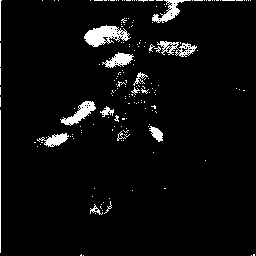

In [0]:
'''a = result>0.5
print(a)
b = a.astype(int)
print(b)
cv2_imshow(b)'''
result[result > .5] = 255
result[result <= .5] = 0
print(result)
cv2_imshow(result)
